# Deep Convolutional Generative Adversarial Networks 

In [1]:
# Imports
import keras
from keras.models import Sequential
from keras.layers import Conv2D, Flatten, Dropout, Dense, UpSampling2D, Reshape
from keras.layers import Conv2DTranspose, Activation, BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import RMSprop
from keras.datasets import cifar10

Using TensorFlow backend.


In [2]:
%matplotlib inline
import matplotlib.pylab as plt

from tqdm import tnrange
import numpy as np
from sklearn.preprocessing import OneHotEncoder

In [3]:
# Informações dos dados de entrada
img_rows = 32
img_cols = 32
channel = 3
classes = 10

In [4]:
# Hiperparâmetros
depth = 64
dropout = 0.4

## Discriminator Network

Leaky ReLUs são uma tentativa de consertar o problema do “dying ReLU”. Ao invés da função ser zero quando x < 0, a leaky ReLU terá uma pequena inclinação negativa (de 0.01, por exemplo). Ou seja, a função calcula f(x)=𝟙(x<0)(αx)+𝟙(x>=0)(x) onde α é uma constante.

In [5]:
discriminator = Sequential()

input_shape = (img_rows, img_cols, channel)

discriminator.add(Conv2D(depth*1, 5, strides=2, input_shape=input_shape, padding='same'))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(dropout))

discriminator.add(Conv2D(depth*2, 5, strides=2, padding='same'))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(dropout))

discriminator.add(Conv2D(depth*4, 5, strides=2, padding='same'))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(dropout))

discriminator.add(Conv2D(depth*8, 5, strides=1, padding='same'))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(dropout))

discriminator.add(Flatten())
discriminator.add(Dense(classes + 1))
discriminator.add(Activation('softmax'))

discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 256)         819456    
__________

## Perda e Otimização do Discriminator

In [7]:
# Otimizador
optimizer = RMSprop(lr=0.0001, decay=6e-8)

# Criação do Modelo
discriminator_model = Sequential()
discriminator_model.add(discriminator)

# Compilação
discriminator_model.compile(loss = 'categorical_crossentropy', optimizer = optimizer, metrics = ['accuracy'])

## Generator Network

In [8]:
# Hiperparâmetros
dropout = 0.4
depth = 64+64+64+64
dim = 8

In [9]:
generator = Sequential()

generator.add(Dense(dim*dim*depth, input_dim=100 + classes))
generator.add(BatchNormalization(momentum=0.9))
generator.add(Activation('relu'))
generator.add(Reshape((dim, dim, depth)))
generator.add(Dropout(dropout))

generator.add(UpSampling2D())
generator.add(Conv2DTranspose(int(depth/2), 5, padding='same'))
generator.add(BatchNormalization(momentum=0.9))
generator.add(Activation('relu'))

generator.add(UpSampling2D())
generator.add(Conv2DTranspose(int(depth/4), 5, padding='same'))
generator.add(BatchNormalization(momentum=0.9))
generator.add(Activation('relu'))

generator.add(Conv2DTranspose(3, 5, padding='same'))
generator.add(Activation('sigmoid'))

generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 16384)             1818624   
_________________________________________________________________
batch_normalization_1 (Batch (None, 16384)             65536     
_________________________________________________________________
activation_2 (Activation)    (None, 16384)             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 8, 8, 256)         0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 8, 8, 256)         0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 16, 16, 256)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 16, 16, 128)       819328    
__________

## Perda e Otimização do Generator e Criação do Modelo

In [10]:
# Otimizador
optimizer = RMSprop(lr=0.0004, clipvalue=1.0, decay=3e-8)

# Criação do Modelo
adversarial_model = Sequential()
adversarial_model.add(generator)
discriminator.trainable = False
adversarial_model.add(discriminator)

# Compilação do Modelo
adversarial_model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
adversarial_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_4 (Sequential)    (None, 32, 32, 3)         2913923   
_________________________________________________________________
sequential_1 (Sequential)    (None, 11)                4396683   
Total params: 7,310,606
Trainable params: 2,880,771
Non-trainable params: 4,429,835
_________________________________________________________________


## Treinamento

In [11]:
# Carregando os dados
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train = np.concatenate((x_train, x_test))
y_train = np.concatenate((y_train, y_test))

170500096/170498071 [==============================] - 28s 0us/step


In [12]:
# Normalização
def normalize(images):
    images=images.astype('float32')
    if images.max() > 1.0:
        images/=255.0
    return images

In [13]:
# One-Hot Encoding
def one_hot(labels):
    enc = OneHotEncoder()
    return enc.fit_transform(y_train).toarray()

In [14]:
x_train = normalize(x_train)
y_train = one_hot(y_train)

In [15]:
# Gerando noise randômico para os dados de entrada
def create_generator_noise(batch_size):
    noise = np.random.uniform(-1.0, 1.0, size=[batch_size, 100])
    sampling = np.random.randint(classes, size=batch_size)
    noise_labels = np.zeros((batch_size, classes))
    noise_labels[np.arange(batch_size), sampling] = 1
    noise_input = np.concatenate((noise, noise_labels), axis=1)
    
    return noise_input, noise_labels

In [16]:
# Gerando noise randômico para os labels
def create_generator_noise_by_label(labels):
    noise = np.random.uniform(-1.0, 1.0, size=[len(labels), 100])

    noise_labels = np.zeros((len(labels), classes))
    noise_labels[np.arange(len(labels)), labels] = 1
    noise_input = np.concatenate((noise, noise_labels), axis=1)
    
    return noise_input

In [17]:
def train(batch_size=256, train_steps=2000):
    discriminator_losses = []
    adversarial_losses = []
    sample_images = []
    
    for i in tnrange(train_steps):
        # Seleciona uma amostra aleatória dos dados de treinamento e os rótulos
        sample_idx = np.random.randint(0, x_train.shape[0], size=batch_size)
        images_train = x_train[sample_idx, :, :, :]
        labels_train = y_train[sample_idx]
        labels_train = np.concatenate((labels_train, np.zeros(shape=(batch_size, 1))), axis=1)
        
        # Cria ruído no intervalo -1 a 1 e rótulos aleatórios como entrada para o gerador para gerar as imagens falsas
        noise_input, _ = create_generator_noise(batch_size)
        images_fake = generator.predict(noise_input)
        
        # Cria entrada por concatenar imagens reais e falsas e atribuindo os respectivos rótulos
        labels_fake = np.zeros(shape=(batch_size, classes+1))
        labels_fake[:,-1] = 1
        
        input_data   = np.concatenate((images_train, images_fake))
        input_labels = np.concatenate((labels_train, labels_fake))

        discriminator_loss = discriminator_model.train_on_batch(input_data, input_labels)
        
        # Treina o modelo adversarial para gerar melhores imagens
        noise_input, noise_labels = create_generator_noise(batch_size)
        noise_labels = np.concatenate((noise_labels, np.zeros(shape=(batch_size, 1))), axis=1)
        
        adversarial_loss = adversarial_model.train_on_batch(noise_input, noise_labels)
        
        discriminator_losses.append(discriminator_loss)
        adversarial_losses.append(adversarial_loss)
        
        if i % 100 == 0:
            labels = [1]
            noise = create_generator_noise_by_label(labels)
            fake_images = generator.predict(noise)
            sample_images.append(fake_images[0])
    
    return discriminator_losses, adversarial_losses, sample_images

In [18]:
# Treinamento
discriminator_losses, adversarial_losses, sample_images  = train(train_steps=20000)

/opt/conda/lib/python3.6/site-packages/Keras-2.2.4-py3.6.egg/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


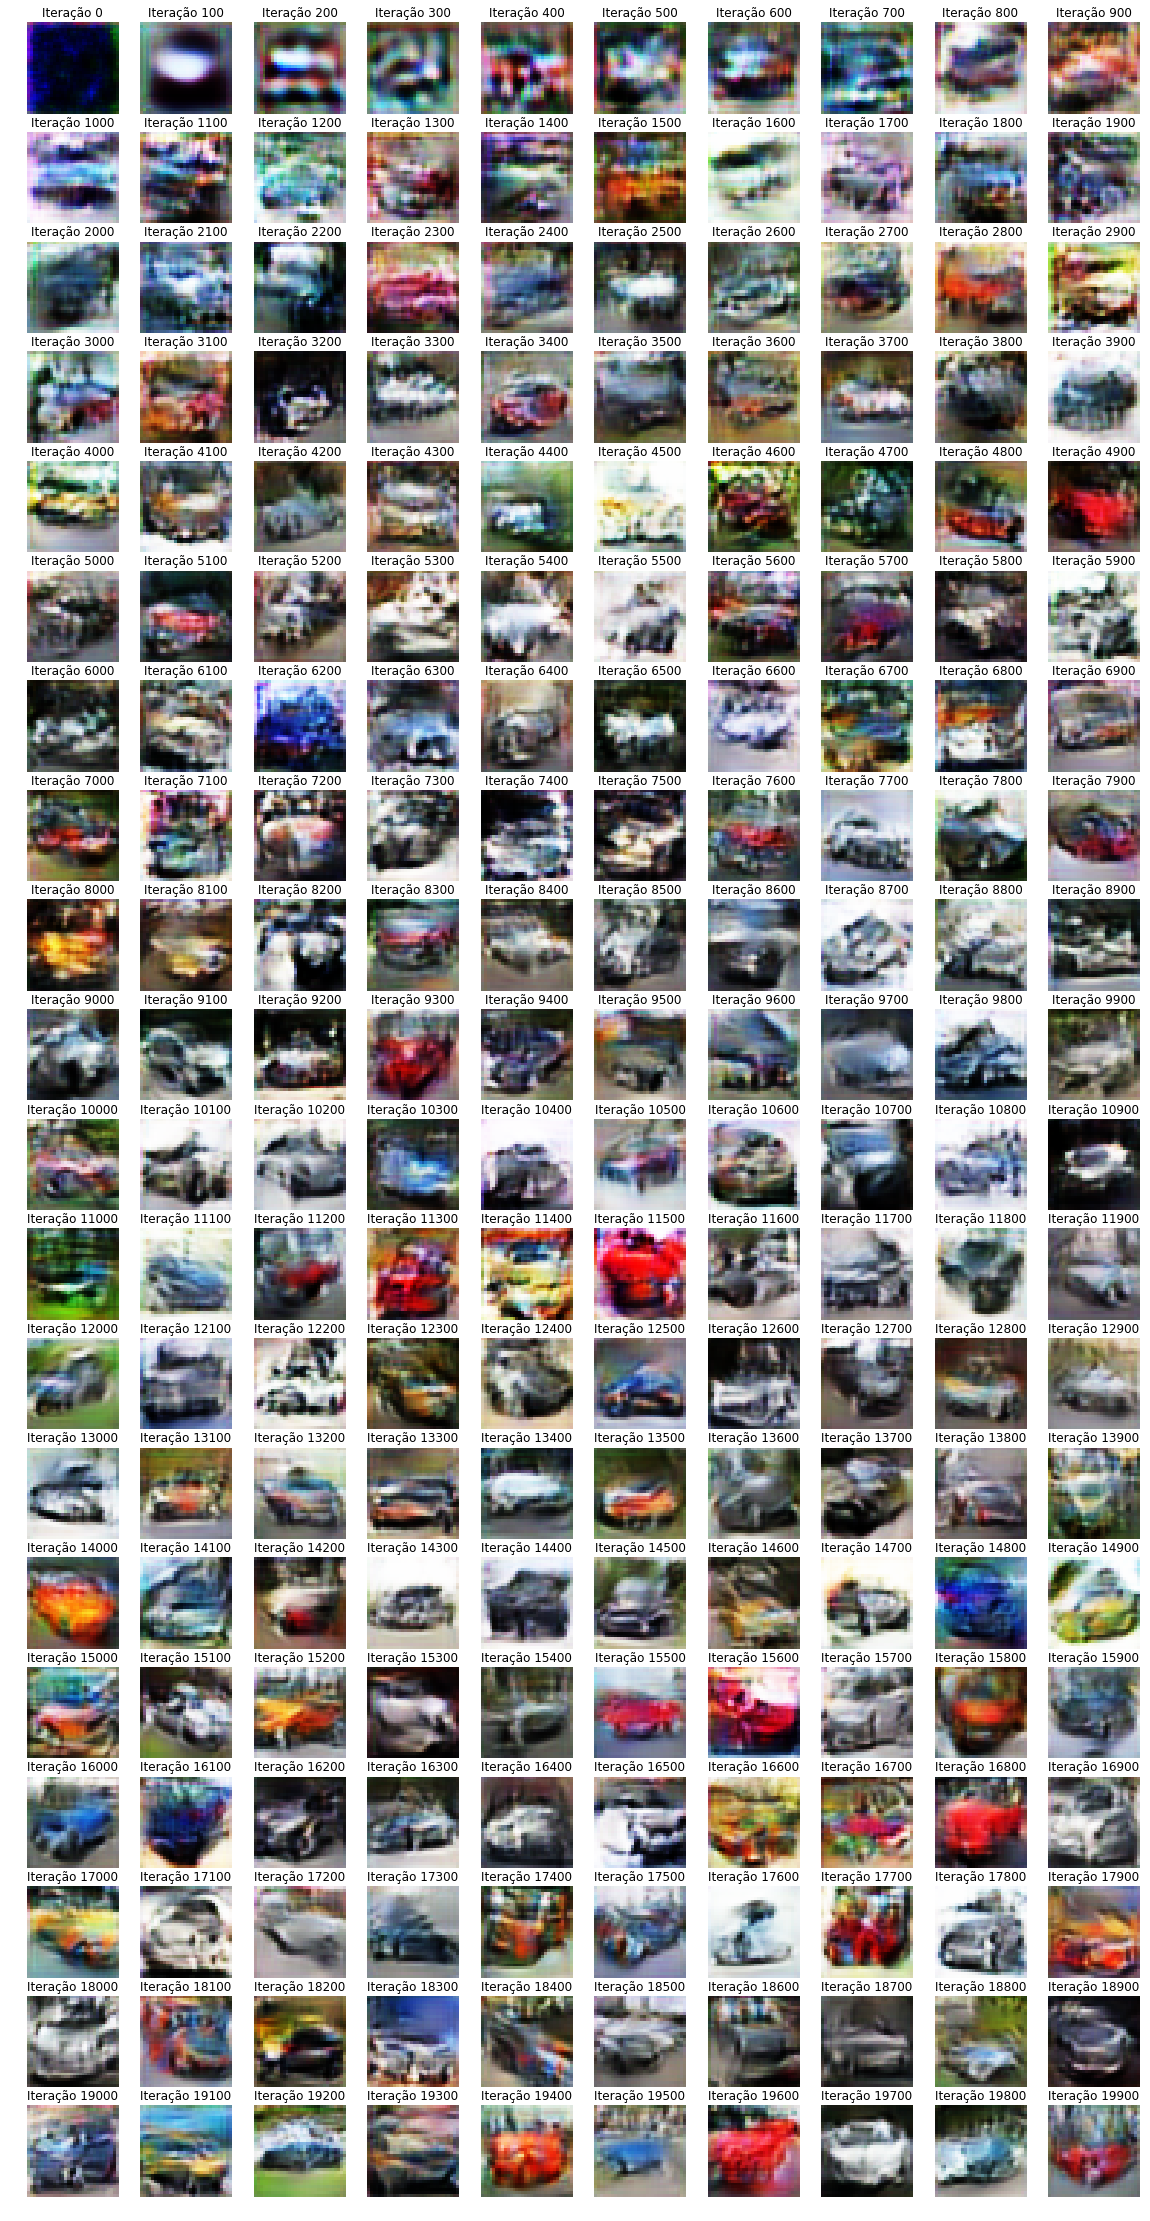

In [20]:
# Print do resultado
plt.figure(figsize=(20,40))
for i, fake_image in enumerate(sample_images, 0):
    plt.subplot(20, 10, i+1)
    plt.imshow(np.reshape(fake_image, (img_cols, img_rows, channel)), cmap='gray')
    plt.title("Iteração %d" % (i * 100))
    plt.axis('off')

Text(0.5,1,'Acurácia do Generator')

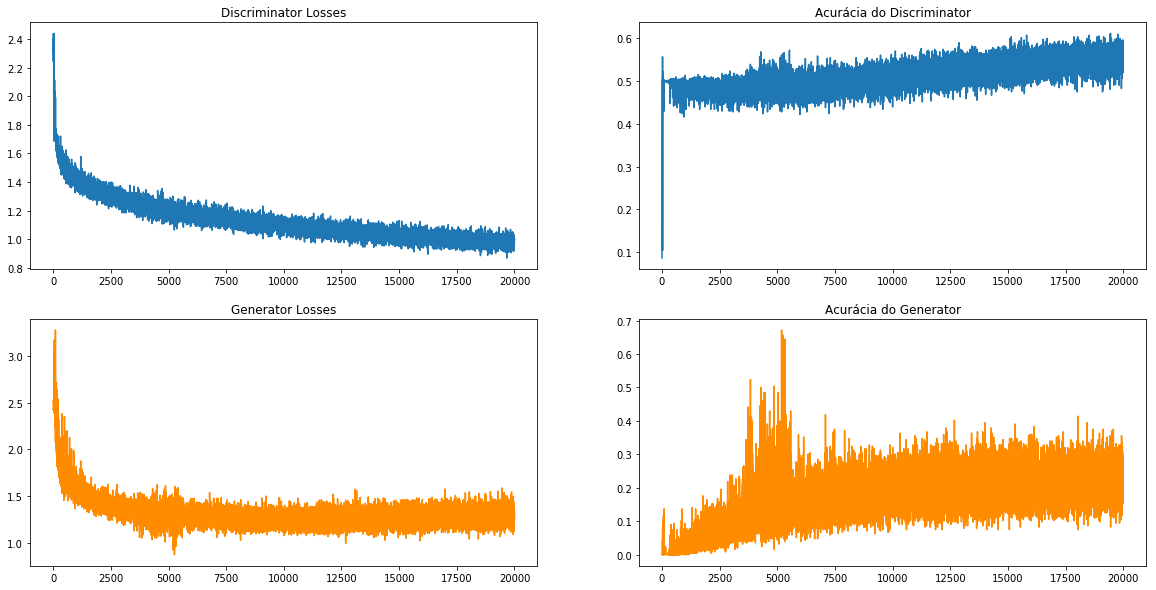

In [21]:
# Print do treinamento
plt.figure(figsize=(20,10))

plt.subplot(2,2,1)
plt.plot(np.array(discriminator_losses)[:, 0])
plt.title("Discriminator Losses")

plt.subplot(2,2,2)
plt.plot(np.array(discriminator_losses)[:, 1])
plt.title("Acurácia do Discriminator")

plt.subplot(2,2,3)
plt.plot(np.array(adversarial_losses)[:, 0], color='darkorange')
plt.title("Generator Losses")

plt.subplot(2,2,4)
plt.plot(np.array(adversarial_losses)[:, 1], color='darkorange')
plt.title("Acurácia do Generator")

## Gerando Imagens com Etiquetas de Classe Dadas

In [22]:
label_names = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

In [23]:
def sample_labels(size):
    labels = []
    for label, _ in enumerate(label_names):
        for sample_size in range(size):
            labels.append(label)
    return labels

/opt/conda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


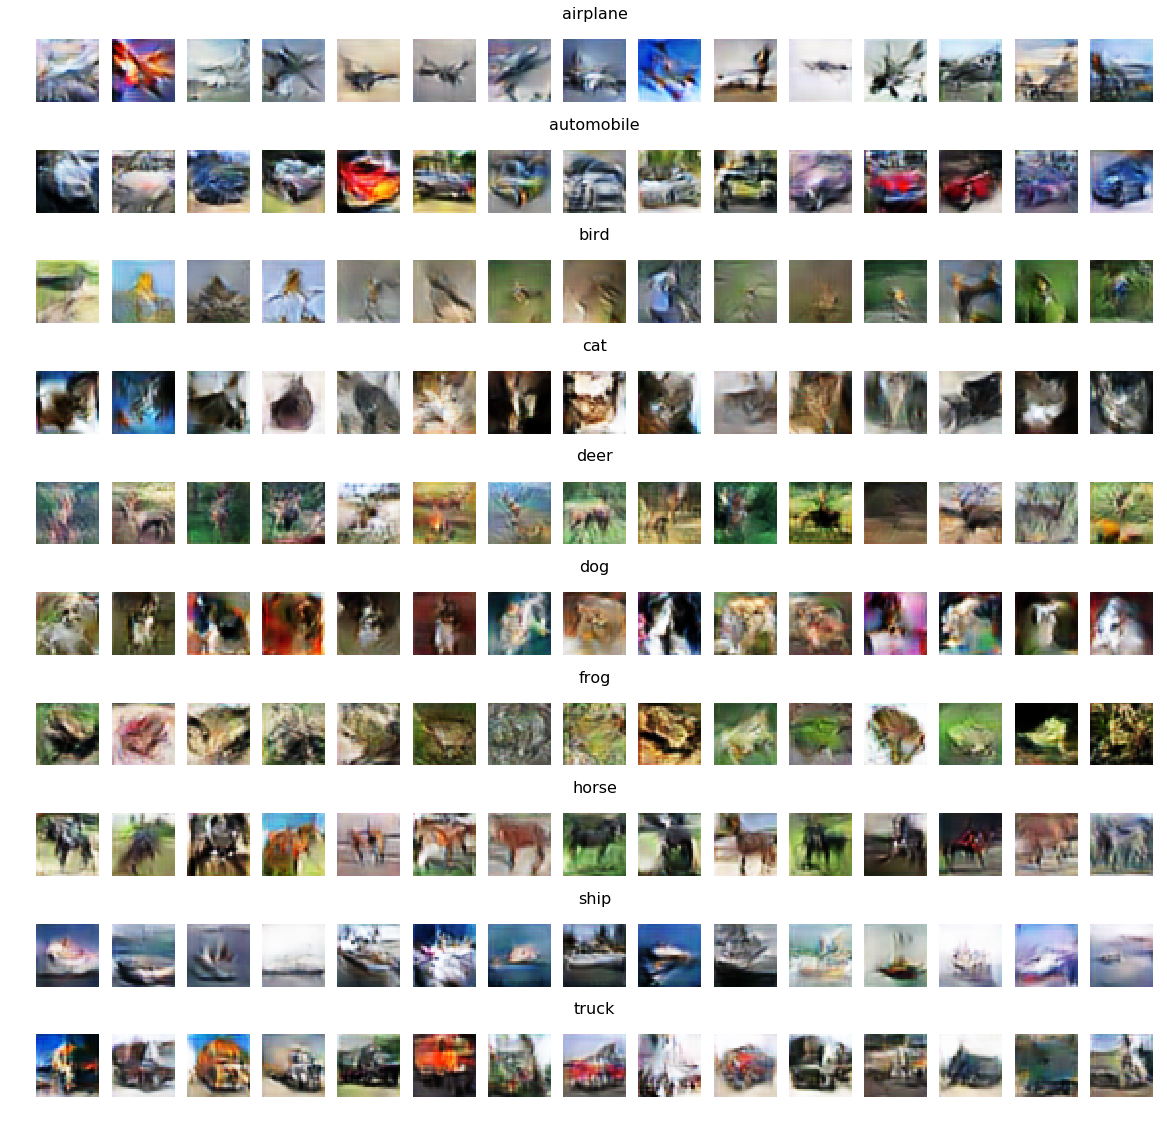

<Figure size 1440x1440 with 0 Axes>

In [24]:
fig, big_axes = plt.subplots(figsize=(20, 20) , nrows=len(label_names), ncols=1, sharey=True) 

for row, big_ax in enumerate(big_axes, start=1):
    big_ax.set_title(label_names[row-1], fontsize=16)
    big_ax.tick_params(labelcolor=(1.,1.,1., 0.0), top='off', bottom='off', left='off', right='off')
    big_ax._frameon = False

labels = sample_labels(15)
noise = create_generator_noise_by_label(labels)

fake_images = generator.predict(noise)

plt.figure(figsize=(20,20))
for i, fake_image in enumerate(fake_images, 1):
    ax = fig.add_subplot(len(label_names), 15, i)
    ax.imshow(np.reshape(fake_image, (img_cols, img_rows, channel)), cmap='gray')
    ax.axis('off')